# FINM33150 - Quant Trading Strategies
## Homework 2
## University of Chicago


### Author: Laurent Lanteigne
### ID: 12279717
### Date: April 15th, 2021

 # 1. Data
 
 Student ID finishes with 7 so the pair is (RING, GDX)

In [89]:
%matplotlib inline

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import datetime
import functools
import seaborn as sns
import plotnine as p9
import os
import copy
import time
from scipy.stats import norm
import statsmodels.api as sm
plt.style.use('fivethirtyeight')

quandl_key = os.environ.get('QUANDL_API_KEY') # Works now, might need to reset env or computer to have it work 

In [91]:
try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(my_securities, start, end):
        print("Fetching from Quandl")
        qdata = quandl.get(list(my_securities), returns="pandas",
                          api_key=quandl_key,
                          start_date=start, end_date=end)
        return qdata
    print("fetch_quandl has now been newly defined")

fetch_quandl already defined


In [92]:
start = "2018-12-02"
end = "2020-12-31"
pair = ("EOD/RING", "EOD/GDX")
raw_data = fetch_quandl(pair, start, end)
raw_data.head()

,EOD/RING - Open,EOD/RING - High,EOD/RING - Low,EOD/RING - Close,EOD/RING - Volume,EOD/RING - Dividend,EOD/RING - Split,EOD/RING - Adj_Open,EOD/RING - Adj_High,EOD/RING - Adj_Low,...,EOD/GDX - Low,EOD/GDX - Close,EOD/GDX - Volume,EOD/GDX - Dividend,EOD/GDX - Split,EOD/GDX - Adj_Open,EOD/GDX - Adj_High,EOD/GDX - Adj_Low,EOD/GDX - Adj_Close,EOD/GDX - Adj_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-03,14.94,15.0732,14.84,15.06,67643.0,0.0,1.0,14.620305,14.750654,14.522444,...,19.160,19.44,47854584.0,0.0,1.0,19.045315,19.143538,18.819404,19.094426,47854584.0
2018-12-04,15.50,15.5000,15.13,15.16,93202.0,0.0,1.0,15.168321,15.168321,14.806239,...,19.525,19.60,45431957.0,0.0,1.0,19.320338,19.418560,19.177915,19.251582,45431957.0
2018-12-06,15.22,15.4600,15.15,15.27,227208.0,0.0,1.0,14.894313,15.129177,14.825811,...,19.500,19.71,50908337.0,0.0,1.0,19.310516,19.546249,19.153360,19.359627,50908337.0
2018-12-07,15.41,15.7400,15.36,15.69,98311.0,0.0,1.0,15.080247,15.403186,15.031317,...,19.790,20.20,67726791.0,0.0,1.0,19.526605,19.973516,19.438205,19.840916,67726791.0
2018-12-10,15.80,15.9300,15.55,15.67,193562.0,0.0,1.0,15.461902,15.589120,15.217251,...,19.990,20.13,47460702.0,0.0,1.0,19.742694,20.184695,19.634649,19.772161,47460702.0


In [93]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

In [94]:
pair_data = clean_quandl_columns(raw_data)[['RING:Adj_Close','RING:Adj_Volume', 'GDX:Adj_Close','GDX:Adj_Volume']]
ring_data = pair_data[['RING:Adj_Close','RING:Adj_Volume']]
gdx_data = pair_data[['GDX:Adj_Close','GDX:Adj_Volume']]

def augment_df(df):
    ticker = df.columns[0].split(':')[0]
    df[ticker+':'+'Dollar_Volume'] = df[df.columns[0]] * df[df.columns[1]]
    df[ticker+':'+'15Day_Running_Median'] = df[ticker+':'+'Dollar_Volume'].shift(1).rolling(15).median()
    return df

ring_data = augment_df(ring_data)
gdx_data = augment_df(gdx_data)
data = ring_data.merge(gdx_data, left_index=True, right_index=True)

<ipython-input-94-4c69949ca79e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
ff_path = 'F-F_Research_Data_Factors_daily.CSV'
ff_df = pd.read_csv(ff_path)
ff_df.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,19260701,0.10,-0.24,-0.28,0.009
1,19260702,0.45,-0.32,-0.08,0.009
2,19260706,0.17,0.27,-0.35,0.009
3,19260707,0.09,-0.59,0.03,0.009
4,19260708,0.21,-0.36,0.15,0.009


In [96]:
ff_df.rename(columns={'Unnamed: 0':'Date'}, inplace = True)
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m%d')
ff_df.tail()

,Date,Mkt-RF,SMB,HML,RF
24929,2021-02-22,-1.12,-0.09,3.14,0.0
24930,2021-02-23,-0.15,-1.28,0.90,0.0
24931,2021-02-24,1.15,1.20,1.34,0.0
24932,2021-02-25,-2.73,-1.12,0.87,0.0
24933,2021-02-26,-0.28,0.72,-1.56,0.0


In [97]:
ff_df = ff_df[(start <= ff_df['Date']) & (ff_df['Date'] <= end)]
ff_df = ff_df.set_index('Date')
ff_df.tail()

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-12-24,0.21,-0.39,-0.17,0.0
2020-12-28,0.46,-0.72,0.32,0.0
2020-12-29,-0.40,-1.52,0.24,0.0
2020-12-30,0.27,0.99,0.04,0.0
2020-12-31,0.39,-0.87,0.45,0.0


In [98]:
#df = data.merge(ff_df, left_index=True, right_index=True)
data[['Spread','RING:Mday_ret','GDX:Mday_ret','RING:shares','GDX:shares','RING:pos','GDX:pos','Gross','PnL', 'PnL_Accumulated']] = np.nan
data.head(20)

,RING:Adj_Close,RING:Adj_Volume,RING:Dollar_Volume,RING:15Day_Running_Median,GDX:Adj_Close,GDX:Adj_Volume,GDX:Dollar_Volume,GDX:15Day_Running_Median,Spread,RING:Mday_ret,GDX:Mday_ret,RING:shares,GDX:shares,RING:pos,GDX:pos,Gross,PnL,PnL_Accumulated
Date,,,,,,,,,,,,,,,,,,
2018-12-03,14.737737,67643.0,9.969047e+05,NaN,19.094426,47854584.0,9.137558e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-04,14.835597,93202.0,1.382707e+06,NaN,19.251582,45431957.0,8.746371e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-06,14.943243,227208.0,3.395224e+06,NaN,19.359627,50908337.0,9.855664e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-07,15.354256,98311.0,1.509492e+06,NaN,19.840916,67726791.0,1.343762e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-10,15.334684,193562.0,2.968212e+06,NaN,19.772161,47460702.0,9.384006e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-11,15.207465,87270.0,1.327156e+06,NaN,19.654294,50550836.0,9.935410e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-12,15.540190,122349.0,1.901327e+06,NaN,20.076650,71832271.0,1.442151e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-13,15.540190,38508.0,5.984216e+05,NaN,20.115939,42886328.0,8.626988e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-14,15.119391,175379.0,2.651624e+06,NaN,19.762338,48767202.0,9.637539e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
K = data['RING:15Day_Running_Median'].max()
data['Capital'] = K

Before we go into the spread trading strategy, let's check how correlated our two assets are.

In [100]:
data['GDX:Adj_Close'].pct_change().corr(data['RING:Adj_Close'].pct_change())

0.9648070137245416

Our two assets are heavily correlated.

# 2. Spread Trading Strategy

In [101]:
#params
j, g, s, M = 0.002, 0.005, 0.0025, 10
df = copy.deepcopy(data)
df['RING:Mday_ret'] = np.log(df['RING:Adj_Close']/df['RING:Adj_Close'].shift(M))
df['GDX:Mday_ret'] = np.log(df['GDX:Adj_Close']/df['GDX:Adj_Close'].shift(M))
df['Spread'] = df['GDX:Mday_ret'] - df['RING:Mday_ret']

book_dic = {}
stop_loss_dic = {}
exit_dic = {}
last_month_exit = 0 

pos_df = pd.DataFrame(index = df.index)
pos_df[['Enter Position', 'Exit Position']] = 0 
for date in df.index:
    
    # Initiate the position flag
    if date == df.index[0]:
        pos_flag = False # no initial position
        last_day_flag = False
        yst_date = df.index.get_loc(date) # index of yesterday is 0 if first day
        stop_loss_flag = False 

    else:
        yst_date = df.index.get_loc(date) - 1 #yesterday index
        
        
    tmw_date = df.index.get_loc(date) + 1 #tomorrow index 
    if date == df.index[-1]:
        last_day_flag = True 
    eom_flag = date.day > (date + datetime.timedelta(days=1)).day # flag that let's you know if it is last day of the month 
    
    N_t = df.loc[date, 'RING:15Day_Running_Median'] # Median use
    s_ret = df.loc[date, 'Spread'] # spread return on that date 
    treshold_date = date >= datetime.datetime.fromisoformat('2019-01-01') # starting trade in 2019
    
    
    # Entering position requirements, spread greater than g, not end of month and no position
    if treshold_date and (abs(s_ret) > g) and (eom_flag is False) and (pos_flag is False) and (stop_loss_flag is False):
        pos_flag = True # We open a position
        trade_val = N_t/100 # Value of the trade on each side of the spread 
        df.loc[date,'PnL'] = 0 # PnL for that day is 0 
        pos_df.loc[date, 'Enter Position'] = s_ret
        # Following if/else gives you the amount of shares and the size of position for each asset 
        if np.sign(s_ret) == 1:
            df.loc[date,'RING:shares'] = int(trade_val/df.loc[date,'RING:Adj_Close']) 
            df.loc[date,'RING:pos'] = df.loc[date,'RING:shares'] * df.loc[date,'RING:Adj_Close']
            
            df.loc[date,'GDX:shares'] = -int(trade_val/df.loc[date,'GDX:Adj_Close'])
            df.loc[date,'GDX:pos'] = df.loc[date,'GDX:shares'] * df.loc[date,'GDX:Adj_Close']
        else:
            df.loc[date,'RING:shares'] = -int(trade_val/df.loc[date,'RING:Adj_Close'])
            df.loc[date,'RING:pos'] = df.loc[date,'RING:shares'] * df.loc[date,'RING:Adj_Close']
            
            df.loc[date,'GDX:shares'] = int(trade_val/df.loc[date,'GDX:Adj_Close'])
            df.loc[date,'GDX:pos'] = df.loc[date,'GDX:shares'] * df.loc[date,'GDX:Adj_Close']
        
        # Gross is the sum of the absolution of the positions 
        df.loc[date,'Gross'] = abs(df.loc[date,'RING:pos']) + abs(df.loc[date,'GDX:pos'])
        trade_gross = df.loc[date,'Gross']
        # Log the trade in a dictionary 
        book_dic[date] = "{} RING Shares @ {:.2f} and {} GDX Shares @ {:.2f}".format(df.loc[date,'RING:shares'],df.loc[date,'RING:Adj_Close'],df.loc[date,'GDX:shares'],df.loc[date,'GDX:Adj_Close'] )
            
    # If we have an open position, then calculate the PnL based on yesterday's position        
    elif pos_flag is True:
        df.loc[date,'RING:shares'] = df['RING:shares'].shift(1).loc[date] # Today's end of day share will be how many we bought yesterday's at closing 
        df.loc[date,'GDX:shares'] = df['GDX:shares'].shift(1).loc[date]
        df.loc[date,'RING:pos'] = df['RING:shares'].iloc[yst_date] * df.loc[date,'RING:Adj_Close'] # Today's oosition is the shares times the new price
        df.loc[date,'GDX:pos'] = df['GDX:shares'].iloc[yst_date] * df.loc[date,'GDX:Adj_Close']
        df.loc[date, 'PnL'] = (df.loc[date,'GDX:pos'] + df.loc[date,'RING:pos']) - (df['GDX:pos'].iloc[yst_date] + df['RING:pos'].iloc[yst_date]) # PnL is the difference in position for each asset 
        df.loc[date,'Gross'] = abs(df.loc[date,'RING:pos']) + abs(df.loc[date,'GDX:pos'])
        
        
        rel_pos = df.loc[date, 'PnL']/trade_gross # our relative position vs PnL
        # If relative position is less than threshold then stop loss and no more trading activity for the month 
        if rel_pos < -s:
            stop_loss_flag = True 
            df['RING:pos'].iloc[tmw_date]  = 0.0
            df['GDX:pos'].iloc[tmw_date]  = 0.0
            df['RING:shares'].iloc[tmw_date]  = 0.0
            df['GDX:shares'].iloc[tmw_date]  = 0.0
            df['Gross'].iloc[tmw_date]  = 0.0
            df['PnL'].iloc[tmw_date]  = 0.0
            pos_flag = False 
            stop_loss_dic[date] = "Stop Loss Threshold = -{}%, PnL = {:.2f}, Gross Position = {:.2f}, Relative Position = {:.4f}%".format(100*s,df.loc[date, 'PnL'],trade_gross,100*rel_pos)
            pos_df.loc[date, 'Exit Position'] = s_ret
            
        # If spread is less than j then flatten the position by changing tomorrow initial shares to 0, since we are flat there is no PnL tomorrow 
        if abs(s_ret) < j and last_day_flag is False:
            df['RING:pos'].iloc[tmw_date]  = 0.0
            df['GDX:pos'].iloc[tmw_date]  = 0.0
            df['RING:shares'].iloc[tmw_date]  = 0.0
            df['GDX:shares'].iloc[tmw_date]  = 0.0
            df['Gross'].iloc[tmw_date]  = 0.0
            df['PnL'].iloc[tmw_date]  = 0.0
            pos_flag = False 
            pos_df.loc[date, 'Exit Position'] = s_ret
            exit_dic[date] = "{} RING Shares @ {:.2f} and {} GDX Shares @ {:.2f}".format(df.loc[date,'RING:shares'],df.loc[date,'RING:Adj_Close'],df.loc[date,'GDX:shares'],df.loc[date,'GDX:Adj_Close'] )
            
            
    
    # If end of the month, we exist position
    if eom_flag is True and last_day_flag is False:
        df['RING:pos'].iloc[tmw_date]  = 0.0
        df['GDX:pos'].iloc[tmw_date]  = 0.0
        df['RING:shares'].iloc[tmw_date]  = 0.0
        df['GDX:shares'].iloc[tmw_date]  = 0.0
        df['Gross'].iloc[tmw_date]  = 0.0
        df['PnL'].iloc[tmw_date]  = 0.0
        
        if pos_flag is True:
            pos_df.loc[date, 'Exit Position'] = s_ret
            exit_dic[date] = "{} RING Shares @ {:.2f} and {} GDX Shares @ {:.2f}".format(df.loc[date,'RING:shares'],df.loc[date,'RING:Adj_Close'],df.loc[date,'GDX:shares'],df.loc[date,'GDX:Adj_Close'] )
            last_month_exit += 1
        # Reset the flags and trade_gross
        pos_flag = False 
        stop_loss_flag = False 
        trade_gross = 0 
        
    # If we have an open position on the last trading day, close it and log it.
    if last_day_flag is True and pos_flag is True:
        pos_flag = False
        pos_df.loc[date, 'Exit Position'] = s_ret
        exit_dic[date] = "{} RING Shares @ {:.2f} and {} GDX Shares @ {:.2f}".format(df.loc[date,'RING:shares'],df.loc[date,'RING:Adj_Close'],df.loc[date,'GDX:shares'],df.loc[date,'GDX:Adj_Close'] )
        last_month_exit += 1
        
# Cleaning the dataframe       
df = df.fillna(0)
df['PnL_Accumulated'] = df['PnL'].cumsum()
df['Capital'] = df['Capital']+ df['PnL_Accumulated'][pos_df['Exit Position'] != 0]
df['Capital'] = df['Capital'].fillna(method='bfill')
# Printing out the first 2 months to see how it works 
df['2019-01-01':'2019-03-01']

,RING:Adj_Close,RING:Adj_Volume,RING:Dollar_Volume,RING:15Day_Running_Median,GDX:Adj_Close,GDX:Adj_Volume,GDX:Dollar_Volume,GDX:15Day_Running_Median,Spread,RING:Mday_ret,GDX:Mday_ret,RING:shares,GDX:shares,RING:pos,GDX:pos,Gross,PnL,PnL_Accumulated,Capital
Date,,,,,,,,,,,,,,,,,,,
2019-01-02,15.974148,226463.0,3.617554e+06,2.762499e+06,20.793839,39923469.0,8.301622e+08,1.260564e+09,-0.001355,0.028172,0.026817,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.378152e+07
2019-01-03,16.288136,189799.0,3.091472e+06,2.762499e+06,21.218607,52553642.0,1.115115e+09,1.260564e+09,-0.004086,0.028102,0.024016,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.378152e+07
2019-01-04,16.190015,149762.0,2.424649e+06,2.769731e+06,21.040797,60253682.0,1.267786e+09,1.260564e+09,-0.006300,0.077470,0.071170,-1710.0,1316.0,-27684.925929,27689.689123,55374.615052,0.000000,0.000000,1.378152e+07
2019-01-07,16.023209,147186.0,2.358392e+06,2.769731e+06,20.783961,41228311.0,8.568876e+08,1.260564e+09,-0.005803,0.023545,0.017742,-1710.0,1316.0,-27399.687298,27351.692918,54751.380216,-52.757574,-52.757574,1.378152e+07
2019-01-08,15.993773,140844.0,2.252627e+06,2.769731e+06,20.793839,36309054.0,7.550046e+08,1.260564e+09,-0.004918,0.034325,0.029407,-1710.0,1316.0,-27349.351069,27364.692772,54714.043841,63.336083,10.578509,1.378152e+07
2019-01-09,16.278324,67925.0,1.105705e+06,2.769731e+06,21.060554,55349595.0,1.165693e+09,1.260564e+09,-0.009245,0.020092,0.010847,-1710.0,1316.0,-27835.934616,27715.688831,55551.623447,-135.587487,-125.008979,1.378152e+07
2019-01-10,16.052645,87988.0,1.412440e+06,2.769731e+06,20.744448,38185638.0,7.921400e+08,1.165693e+09,-0.004615,0.022876,0.018261,-1710.0,1316.0,-27450.023527,27299.693502,54749.717029,-30.084241,-155.093220,1.378152e+07
2019-01-11,16.131142,74159.0,1.196269e+06,2.769731e+06,20.823474,32955556.0,6.862492e+08,1.122221e+09,-0.006393,0.011624,0.005232,-1710.0,1316.0,-27584.253471,27403.692334,54987.945805,-30.231112,-185.324331,1.378152e+07
2019-01-14,15.885839,131773.0,2.093325e+06,2.762499e+06,20.675300,34544288.0,7.142135e+08,1.115115e+09,0.003462,0.012430,0.015892,-1710.0,1316.0,-27164.784896,27208.694523,54373.479420,224.470764,39.146433,1.378152e+07


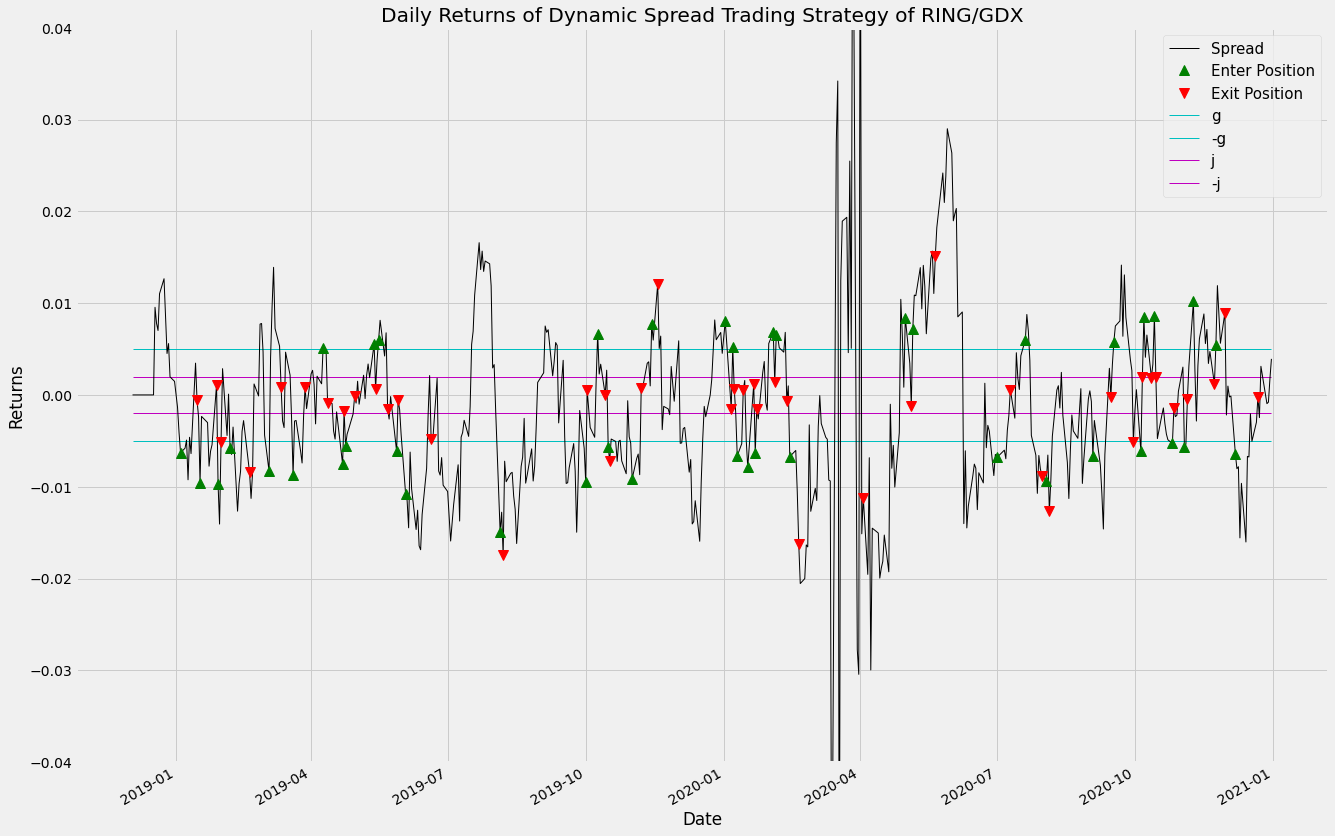

In [102]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)

df['Spread'].plot(c = 'k',lw = 1)
ax.plot(pos_df[pos_df['Enter Position'] != 0].index,pos_df['Enter Position'][pos_df['Enter Position'] != 0], '^',markersize = 10, c='g', label='Enter Position')
ax.plot(pos_df[pos_df['Exit Position'] != 0].index,pos_df['Exit Position'][pos_df['Exit Position'] != 0], 'v',markersize = 10, c='red', label='Exit Position')
ax.set_title('Daily Returns of Dynamic Spread Trading Strategy of RING/GDX')
ax.set_ylabel('Returns')
ax.set_ylim([-0.04,0.04])
ax.hlines(y=g, xmin = df.index[0], xmax = df.index[-1], color = 'c', lw=1, label ='g')
ax.hlines(y=-g, xmin = df.index[0], xmax = df.index[-1], color = 'c', lw=1, label ='-g')
ax.hlines(y=j, xmin = df.index[0], xmax = df.index[-1], color = 'm', lw=1, label ='j')
ax.hlines(y=-j, xmin = df.index[0], xmax = df.index[-1], color = 'm', lw=1, label ='-j')
ax.legend(fontsize = 15)
plt.show()

In [103]:
counter = 0 
# See what the 10 first trades are in order to assess if matches the dataframe above 
for k,v in book_dic.items():
    print(k,v)
    counter+=1
    if counter == 10:
        break
print('\n')
counter = 0 
for k,v in stop_loss_dic.items():
    print(k,v)
    counter+=1
    if counter == 10:
        break


2019-01-04 00:00:00 -1710.0 RING Shares @ 16.19 and 1316.0 GDX Shares @ 21.04
2019-01-17 00:00:00 -1644.0 RING Shares @ 15.82 and 1274.0 GDX Shares @ 20.41
2019-01-29 00:00:00 -1628.0 RING Shares @ 16.84 and 1263.0 GDX Shares @ 21.70
2019-02-06 00:00:00 -2014.0 RING Shares @ 17.11 and 1570.0 GDX Shares @ 21.95
2019-03-04 00:00:00 -1979.0 RING Shares @ 16.87 and 1547.0 GDX Shares @ 21.58
2019-03-20 00:00:00 -1380.0 RING Shares @ 17.47 and 1078.0 GDX Shares @ 22.35
2019-04-09 00:00:00 1390.0 RING Shares @ 17.55 and -1082.0 GDX Shares @ 22.54
2019-04-22 00:00:00 -1214.0 RING Shares @ 16.22 and 950.0 GDX Shares @ 20.72
2019-04-24 00:00:00 -1298.0 RING Shares @ 16.26 and 1016.0 GDX Shares @ 20.76
2019-05-13 00:00:00 1292.0 RING Shares @ 16.04 and -1003.0 GDX Shares @ 20.68


2019-02-19 00:00:00 Stop Loss Threshold = -0.25%, PnL = -282.18, Gross Position = 68925.16, Relative Position = -0.4094%
2019-06-20 00:00:00 Stop Loss Threshold = -0.25%, PnL = -75.71, Gross Position = 22833.44, Relativ

The strategy seems to be well implemented, where the entry points are above the absolute value of g and the stoploss are only triggered when under the treshold. One thing to notice in the graphic is that some exit points don't fall in the range of j, but we can look at our exit points that were not stop loss more in details. 

In [104]:
for k,v in exit_dic.items():
    print(k,v)
print("\n"+"Number of exist points for having a position at the end of the month is {}".format(last_month_exit))

2019-01-15 00:00:00 -1710.0 RING Shares @ 15.56 and 1316.0 GDX Shares @ 20.36
2019-01-28 00:00:00 -1644.0 RING Shares @ 16.40 and 1274.0 GDX Shares @ 21.19
2019-01-31 00:00:00 -1628.0 RING Shares @ 17.35 and 1263.0 GDX Shares @ 22.41
2019-03-12 00:00:00 -1979.0 RING Shares @ 17.41 and 1547.0 GDX Shares @ 22.40
2019-03-28 00:00:00 -1380.0 RING Shares @ 17.27 and 1078.0 GDX Shares @ 22.14
2019-04-12 00:00:00 1390.0 RING Shares @ 17.08 and -1082.0 GDX Shares @ 21.94
2019-04-23 00:00:00 -1214.0 RING Shares @ 16.08 and 950.0 GDX Shares @ 20.57
2019-04-30 00:00:00 -1298.0 RING Shares @ 16.07 and 1016.0 GDX Shares @ 20.64
2019-05-14 00:00:00 1292.0 RING Shares @ 16.02 and -1003.0 GDX Shares @ 20.59
2019-05-22 00:00:00 1114.0 RING Shares @ 15.74 and -867.0 GDX Shares @ 20.11
2019-05-29 00:00:00 -778.0 RING Shares @ 15.71 and 607.0 GDX Shares @ 20.17
2019-10-02 00:00:00 -3255.0 RING Shares @ 21.79 and 2646.0 GDX Shares @ 27.08
2019-10-14 00:00:00 2783.0 RING Shares @ 21.58 and -2245.0 GDX Share

Looking at the dates of the stop loss, and at the dates where we close our position at the end of the month explains why the exit positions in the graph that don't fall in the corridor of j. Let's now look how the performance of our strategy in terms of accumulated PnL.

In [105]:
strat_pnl = df['PnL_Accumulated'][-1]
strat_pnl

1625.6366870558668

# 3. Optimizing

In [18]:
def cum_pnl_pair_strategy(j, g, s, M, data, threshold_day = '2019-01-01'):
    
    df = copy.deepcopy(data)
    df['RING:Mday_ret'] = np.log(df['RING:Adj_Close']/df['RING:Adj_Close'].shift(M))
    df['GDX:Mday_ret'] = np.log(df['GDX:Adj_Close']/df['GDX:Adj_Close'].shift(M))
    df['Spread'] = df['GDX:Mday_ret'] - df['RING:Mday_ret']

    book_dic = {}
    stop_loss_dic = {}


    pos_df = pd.DataFrame(index = df.index)
    pos_df[['Enter Position', 'Exit Position']] = 0 
    for date in df.index:

        # Initiate the position flag
        if date == df.index[0]:
            pos_flag = False # no initial position
            last_day_flag = False
            yst_date = df.index.get_loc(date) # index of yesterday is 0 if first day
            stop_loss_flag = False 

        else:
            yst_date = df.index.get_loc(date) - 1 #yesterday index


        tmw_date = df.index.get_loc(date) + 1 #tomorrow index 
        if date == df.index[-1]:
            last_day_flag = True 
        eom_flag = date.day > (date + datetime.timedelta(days=1)).day # flag that let's you know if it is last day of the month 

        N_t = df.loc[date, 'RING:15Day_Running_Median'] # Median use
        s_ret = df.loc[date, 'Spread'] # spread return on that date 
        treshold_date = date >= datetime.datetime.fromisoformat(threshold_day) # starting trade in 2019


        # Entering position requirements, spread greater than g, not end of month and no position
        if treshold_date and (abs(s_ret) > g) and (eom_flag is False) and (pos_flag is False) and (stop_loss_flag is False):
            pos_flag = True # We open a position
            trade_val = N_t/100 # Value of the trade on each side of the spread 
            df.loc[date,'PnL'] = 0 # PnL for that day is 0 
            pos_df.loc[date, 'Enter Position'] = s_ret
            # Following if/else gives you the amount of shares and the size of position for each asset 
            if np.sign(s_ret) == 1:
                df.loc[date,'RING:shares'] = int(trade_val/df.loc[date,'RING:Adj_Close']) 
                df.loc[date,'RING:pos'] = df.loc[date,'RING:shares'] * df.loc[date,'RING:Adj_Close']

                df.loc[date,'GDX:shares'] = -int(trade_val/df.loc[date,'GDX:Adj_Close'])
                df.loc[date,'GDX:pos'] = df.loc[date,'GDX:shares'] * df.loc[date,'GDX:Adj_Close']
            else:
                df.loc[date,'RING:shares'] = -int(trade_val/df.loc[date,'RING:Adj_Close'])
                df.loc[date,'RING:pos'] = df.loc[date,'RING:shares'] * df.loc[date,'RING:Adj_Close']

                df.loc[date,'GDX:shares'] = int(trade_val/df.loc[date,'GDX:Adj_Close'])
                df.loc[date,'GDX:pos'] = df.loc[date,'GDX:shares'] * df.loc[date,'GDX:Adj_Close']

            # Gross is the sum of the absolution of the positions 
            df.loc[date,'Gross'] = abs(df.loc[date,'RING:pos']) + abs(df.loc[date,'GDX:pos'])
            trade_gross = df.loc[date,'Gross']
            # Log the trade in a dictionary 
            book_dic[date] = "{} RING Shares @ {:.2f} and {} GDX Shares @ {:.2f}".format(df.loc[date,'RING:shares'],df.loc[date,'RING:Adj_Close'],df.loc[date,'GDX:shares'],df.loc[date,'GDX:Adj_Close'] )

        # If we have an open position, then calculate the PnL based on yesterday's position        
        elif pos_flag is True:
            df.loc[date,'RING:shares'] = df['RING:shares'].shift(1).loc[date] # Today's end of day share will be how many we bought yesterday's at closing 
            df.loc[date,'GDX:shares'] = df['GDX:shares'].shift(1).loc[date]
            df.loc[date,'RING:pos'] = df['RING:shares'].iloc[yst_date] * df.loc[date,'RING:Adj_Close'] # Today's oosition is the shares times the new price
            df.loc[date,'GDX:pos'] = df['GDX:shares'].iloc[yst_date] * df.loc[date,'GDX:Adj_Close']
            df.loc[date, 'PnL'] = (df.loc[date,'GDX:pos'] + df.loc[date,'RING:pos']) - (df['GDX:pos'].iloc[yst_date] + df['RING:pos'].iloc[yst_date]) # PnL is the difference in position for each asset 
            df.loc[date,'Gross'] = abs(df.loc[date,'RING:pos']) + abs(df.loc[date,'GDX:pos'])


            rel_pos = df.loc[date, 'PnL']/trade_gross # our relative position vs PnL
            # If relative position is less than threshold then stop loss and no more trading activity for the month 
            if rel_pos < -s:
                stop_loss_flag = True 
                df['RING:pos'].iloc[tmw_date]  = 0.0
                df['GDX:pos'].iloc[tmw_date]  = 0.0
                df['RING:shares'].iloc[tmw_date]  = 0.0
                df['GDX:shares'].iloc[tmw_date]  = 0.0
                df['Gross'].iloc[tmw_date]  = 0.0
                df['PnL'].iloc[tmw_date]  = 0.0
                pos_flag = False 
                stop_loss_dic[date] = "Stop Loss Threshold = -{}%, PnL = {:.2f}, Gross Position = {:.2f}, Relative Position = {:.4f}%".format(100*s,df.loc[date, 'PnL'],trade_gross,100*rel_pos)
                pos_df.loc[date, 'Exit Position'] = s_ret

            # If spread is less than j then flatten the position by changing tomorrow initial shares to 0, since we are flat there is no PnL tomorrow 
            if abs(s_ret) < j and last_day_flag is False:
                df['RING:pos'].iloc[tmw_date]  = 0.0
                df['GDX:pos'].iloc[tmw_date]  = 0.0
                df['RING:shares'].iloc[tmw_date]  = 0.0
                df['GDX:shares'].iloc[tmw_date]  = 0.0
                df['Gross'].iloc[tmw_date]  = 0.0
                df['PnL'].iloc[tmw_date]  = 0.0
                pos_flag = False 
                pos_df.loc[date, 'Exit Position'] = s_ret



        # If end of the month, we exist position
        if eom_flag is True and last_day_flag is False:
            df['RING:pos'].iloc[tmw_date]  = 0.0
            df['GDX:pos'].iloc[tmw_date]  = 0.0
            df['RING:shares'].iloc[tmw_date]  = 0.0
            df['GDX:shares'].iloc[tmw_date]  = 0.0
            df['Gross'].iloc[tmw_date]  = 0.0
            df['PnL'].iloc[tmw_date]  = 0.0

            if pos_flag is True:
                pos_df.loc[date, 'Exit Position'] = s_ret
            # Reset the flags and trade_gross
            pos_flag = False 
            stop_loss_flag = False 
            trade_gross = 0 

        # If we have an open position on the last trading day, close it and log it.
        if last_day_flag is True and pos_flag is True:
            pos_flag = False
            pos_df.loc[date, 'Exit Position'] = s_ret


    # Cleaning the dataframe       
    df = df.fillna(0)
    df['PnL_Accumulated'] = df['PnL'].cumsum()
    K = df['Capital'].iloc[0]
    
    # Cash Position changes whenever we close a trade
    df['Cash_Pos'] = K + df['PnL_Accumulated'][pos_df['Exit Position'] != 0]
    df['Cash_Pos'].iloc[0] = K
    df['Cash_Pos'] = df['Cash_Pos'].fillna(method='ffill')
    
    df['Capital'] = K + df['PnL_Accumulated']
    
    return df, df['PnL_Accumulated'][-1], pos_df

In [19]:
pnl_arr = []
params_arr = []

start = time.time()
for j in np.linspace(0.001,0.02,20):
    print(str(j) + ' ' + str(time.time()-start))
    for g in np.linspace(0.005,0.05,20):
        if g < j:
            g = j + 0.005
        for s in np.linspace(0.000,0.02,10):
            for M in np.arange(5,16):
                params = (j,g,s,M)
                pnl = cum_pnl_pair_strategy(j,g,s,M,data)[1]
                params_arr.append(params)
                pnl_arr.append(pnl)
end = time.time()

print('Time complete optimization {:.2f}s'.format(end-start))

0.001 0.0
0.002 537.0345990657806
0.003 1087.3661131858826
0.004 1579.7240135669708
0.005 2064.4967052936554
0.006 2569.0495512485504
0.007 3070.8716320991516
0.008 3553.753140449524
0.009000000000000001 3988.7306156158447
0.010000000000000002 4393.99217581749
0.011 4740.039833307266
0.012 5151.227197647095
0.013000000000000001 5501.027079105377
0.014000000000000002 5895.080599784851
0.015 6217.842739105225
0.016 6546.654751777649
0.017 6877.52778339386
0.018000000000000002 7181.097788333893
0.019000000000000003 7471.889510393143
0.02 7780.48412156105
Time complete optimization 8238.05s


In [106]:
best_params = params_arr[np.argmax(np.array(pnl_arr))]
best_pnl = np.max(np.array(pnl_arr))
j,g,s,M = best_params
print("Best Parameters are j={}, g={}, s={:.4f}, M={}".format(j,g,s,M))
print("Best Accumulated PnL with optimized parameters is: {:.2f}".format(best_pnl))

Best Parameters are j=0.02, g=0.025, s=0.0044, M=13
Best Accumulated PnL with optimized parameters is: 23516.89


In [107]:
df_optimized = cum_pnl_pair_strategy(0.02,0.025,0.0044,13,data)[0]
pos_df = cum_pnl_pair_strategy(0.02,0.025,0.0044,13,data)[2]

In [108]:
df_optimized.isnull().sum()

RING:Adj_Close               0
RING:Adj_Volume              0
RING:Dollar_Volume           0
RING:15Day_Running_Median    0
GDX:Adj_Close                0
GDX:Adj_Volume               0
GDX:Dollar_Volume            0
GDX:15Day_Running_Median     0
Spread                       0
RING:Mday_ret                0
GDX:Mday_ret                 0
RING:shares                  0
GDX:shares                   0
RING:pos                     0
GDX:pos                      0
Gross                        0
PnL                          0
PnL_Accumulated              0
Capital                      0
Cash_Pos                     0
dtype: int64

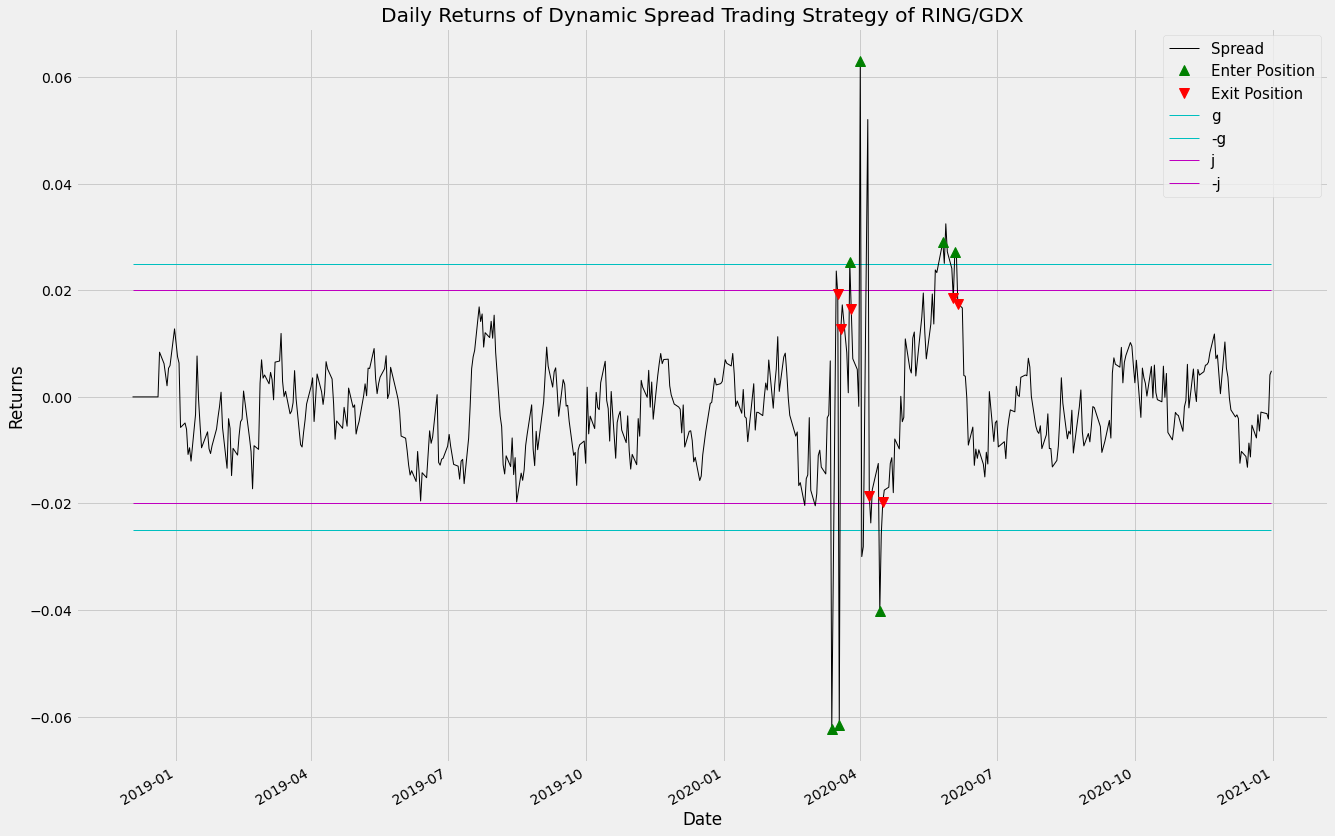

In [109]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
df_optimized['Spread'].plot(c = 'k',lw = 1)
ax.plot(pos_df[pos_df['Enter Position'] != 0].index,pos_df['Enter Position'][pos_df['Enter Position'] != 0], '^',markersize = 10, c='g', label='Enter Position')
ax.plot(pos_df[pos_df['Exit Position'] != 0].index,pos_df['Exit Position'][pos_df['Exit Position'] != 0], 'v',markersize = 10, c='red', label='Exit Position')
ax.set_title('Daily Returns of Dynamic Spread Trading Strategy of RING/GDX')
ax.set_ylabel('Returns')
ax.hlines(y=g, xmin = df_optimized.index[0], xmax = df_optimized.index[-1], color = 'c', lw=1, label ='g')
ax.hlines(y=-g, xmin = df_optimized.index[0], xmax = df_optimized.index[-1], color = 'c', lw=1, label ='-g')
ax.hlines(y=j, xmin = df_optimized.index[0], xmax = df_optimized.index[-1], color = 'm', lw=1, label ='j')
ax.hlines(y=-j, xmin = df_optimized.index[0], xmax = df_optimized.index[-1], color = 'm', lw=1, label ='-j')
ax.legend(fontsize = 15)
plt.show()

In [110]:
pos_df[pos_df['Enter Position'] != 0].count()

Enter Position    7
Exit Position     7
dtype: int64

We only 7 positions, this low amount of data points will surely affect the analysis. Let's look for how long on average we keep our position open. 

In [111]:
enter_pos_idx = pos_df[pos_df['Enter Position'] != 0].index
exit_pos_idx = pos_df[pos_df['Exit Position'] != 0].index
sum((exit_pos_idx-enter_pos_idx).days)/len((exit_pos_idx-enter_pos_idx).days)

3.2857142857142856

Not only is our number of positions small, but the average time that we hold the position is also very small. 

# 4. Analysis

In [1]:
import heapq

Text(0.5, 1.0, 'Change of cash position over time for the trading strategy')

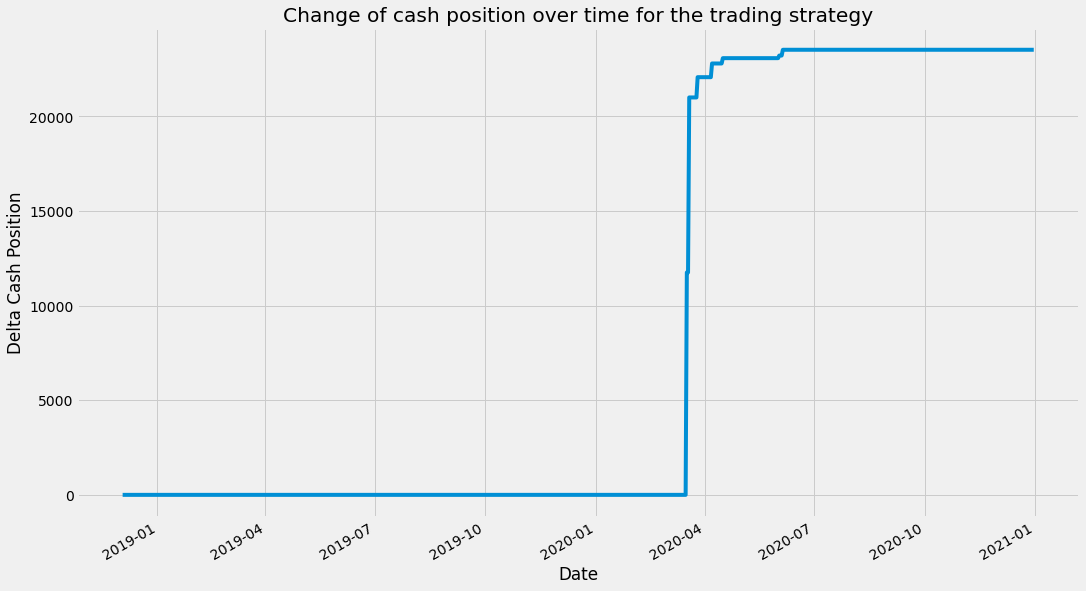

In [112]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)


(df_optimized['Cash_Pos']-df_optimized['Cash_Pos'].iloc[0]).plot()
ax.set_ylabel('Delta Cash Position')
ax.set_title('Change of cash position over time for the trading strategy')
#ax.set_ylim([df_optimized['Capital'].min()-1000, df_optimized['Capital'].max()+1000])

We observe that the optimization really is biased from looking back at the historical data. The parameters are such that there is barely any trading activity until it is able to capture a big chunk of change during the COVID hectic markets. Let's look at the returns to see this. 

Text(0.5, 1.0, 'Returns over time of the trading strategy')

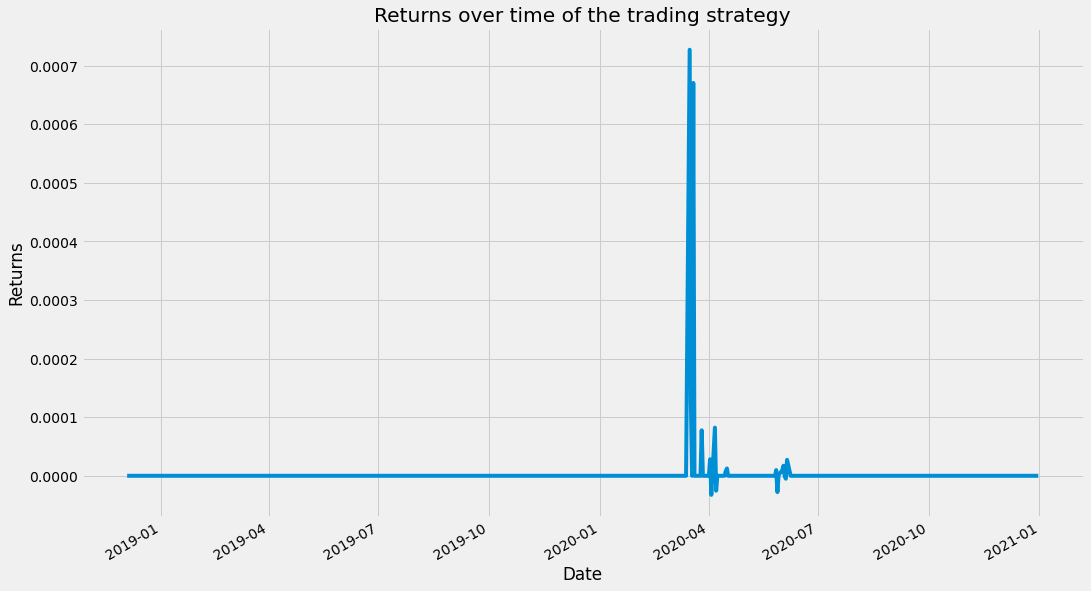

In [113]:
df_optimized['Strat_Returns'] = df_optimized['Capital'].pct_change()

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)

df_optimized['Strat_Returns'].plot()
ax.set_ylabel('Returns')
ax.set_title('Returns over time of the trading strategy')

While the number of the y axis seems extremely small, it is important to note that the starting capital is very large. Let's look at some statistics around the distribution of our returns. 

In [114]:
stats = pd.DataFrame(data = None, columns = ['Strategy Returns'], index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])
data = df_optimized['Strat_Returns']

stats.loc['Mean'] = data.mean()
stats.loc['Median'] = data.median()
stats.loc['Std Dev'] = data.std()
stats.loc['1st Quartile'] = data.quantile(0.25)
stats.loc['3rd Quartile'] = data.quantile(0.75)
stats.loc['Skew'] = sp.stats.skew(data.dropna())
stats.loc['Kurtosis'] = sp.stats.kurtosis(data.dropna())

stats

,Strategy Returns
Mean,0.000003
Median,0.0
Std Dev,0.000044
1st Quartile,0.0
3rd Quartile,0.0
Skew,15.388869
Kurtosis,241.456578


The numbers here are not realistic at all for a viable strategy, the kurtosis is extremely high and fairly positive skewed. These types of nonsensical results follow from overfitting our strategy by optimizing on past data and then running on the strategy on the data that it has been optimized on. Our strategy is extremly biased and the potential to have close to 0 returns on unseen data. The latter comes from the fact that we open a position when the spread is of 0.025 and close it when the spread shrinks to 0.02. Looking at the daily returns of the spread, we see that most day have a return under 0.02 so there will rarely be any trade unless something drastic happens in the market and the spread widdens. Let's look at some statistics about the spread.

In [115]:
spread_stats = pd.DataFrame(data = None, columns = ['Spread Returns'], index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])
data = df_optimized['Spread']

spread_stats.loc['Mean'] = data.mean()
spread_stats.loc['Median'] = data.median()
spread_stats.loc['Std Dev'] = data.std()
spread_stats.loc['1st Quartile'] = data.quantile(0.25)
spread_stats.loc['3rd Quartile'] = data.quantile(0.75)
spread_stats.loc['Skew'] = sp.stats.skew(data.dropna())
spread_stats.loc['Kurtosis'] = sp.stats.kurtosis(data.dropna())

spread_stats

,Spread Returns
Mean,-0.001901
Median,-0.001979
Std Dev,0.01065
1st Quartile,-0.008413
3rd Quartile,0.004097
Skew,0.216007
Kurtosis,7.224259


The kurtosis here is fairly high with a smaller positive skew. One important thing to note here is how small the 1st and 3rd quartiles are compared to the values required for the strategy to enter or exit a position. We can find what percentile of the distribution is required for us to enter and exit a trade. But, before we do that let's look at the normalized spread returns vs a standard normal distribution. 

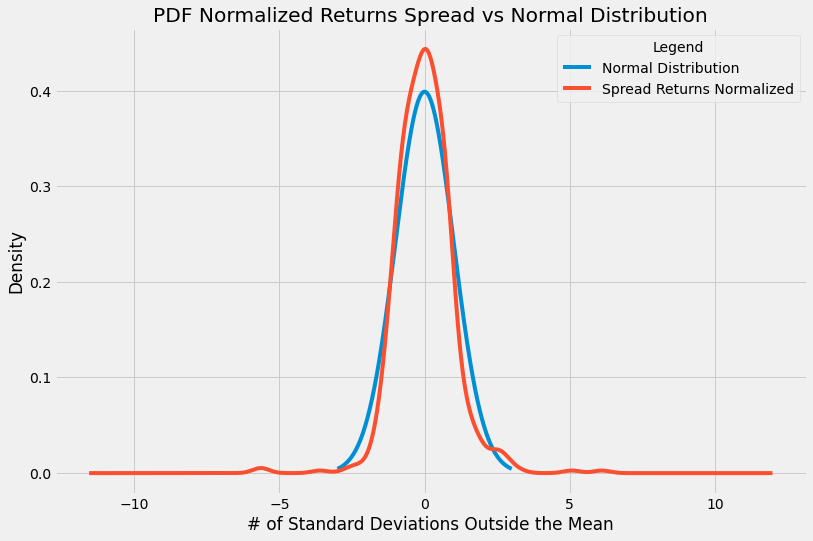

In [116]:
x = np.arange(-3,3,0.001)
y = pd.Series(norm.pdf(x,0,1), index = x, name = 'Normal Distribution')

mean = data.mean()
std = data.std()
df_optimized['Spread Returns Normalized'] = (data - mean)/std

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x,y, label = 'Normal Distribution')
df_optimized['Spread Returns Normalized'].plot.kde()
ax.set_xlabel('# of Standard Deviations Outside the Mean')
ax.set_title('PDF Normalized Returns Spread vs Normal Distribution')
plt.legend(loc='upper right', title='Legend')

We observe the higher kurtosis of our spread versus the normal distribution. Let's test the normality of the spread by running D'Agostino and Pearson's test that tests the null hypothesis that a sample comes from a normal distribution.

In [117]:
print('P-value of the D\'Agostino and Pearson\'s test = {}'.format(sp.stats.normaltest(df_optimized['Spread Returns Normalized'])[1]))

P-value of the D'Agostino and Pearson's test = 4.5298983862415775e-20


 Clearly, the p-value is so small that we should reject the null hypothesis that our returns of the spread are normal. Let's look at some time-series analysis and starting with autocorrelation and partial autocorrelation.

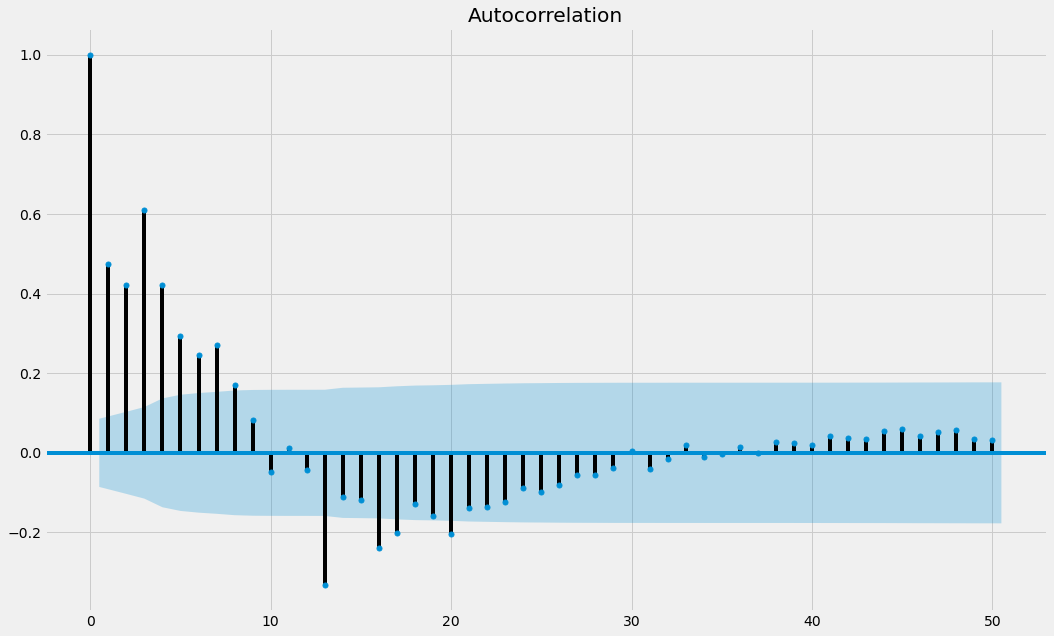

In [118]:
fig1, ax = plt.subplots(figsize=(16,10))
fig1 = sm.graphics.tsa.plot_acf(data, ax = ax, lags = 50)

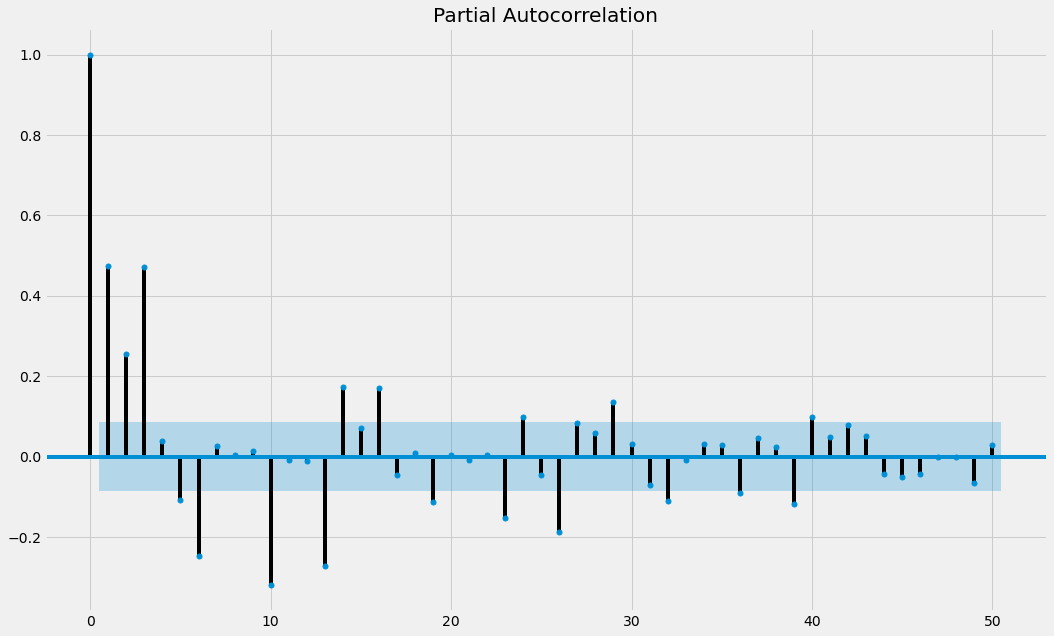

In [119]:
fig1, ax = plt.subplots(figsize=(16,10))
fig1 = sm.graphics.tsa.plot_pacf(data, ax = ax, lags = 50)

There does seem to have some autocorrelation for a short amount of lag in the first graphic and from the partial autocorrelation graph. Let's look at the first values of the acf plots and estimate of the pacf using the Yule-Walker method.

In [120]:
sm.tsa.stattools.acf(data, nlags = 10)

array([ 1.        ,  0.47396756,  0.42121271,  0.6089393 ,  0.42264132,
        0.29439936,  0.24567028,  0.27055478,  0.16985954,  0.083373  ,
       -0.04891106])

In [121]:
sm.tsa.stattools.pacf_yw(data, nlags = 5)

array([ 1.        ,  0.4748738 ,  0.25477435,  0.47199132,  0.03831429,
       -0.10715126])

There is significant amount of lags up to 3 periods where the pacf values are outside of the 95% confidence interval of no partial autocorrelation among the values. We can check for normality using Augmented Dickey Fuller Test.

In [122]:
ADF_spread = sm.tsa.stattools.adfuller(data.dropna().values)
print("ADF Stat: {:.4f} \n p-value: {:.4f}".format(ADF_spread[0], ADF_spread[1]))

ADF Stat: -5.3043 
 p-value: 0.0000


With a ADF value less than (-3.44, -2.87) which are the critical values for the sample size and (1%,5%) confidence interval for t-distribution for sample ~500. Compined with the p-value which is less than 0.05, we cannot say with confidence that our spread returns is not normaly distributed. Let's look if there is any seasonality in the returns.

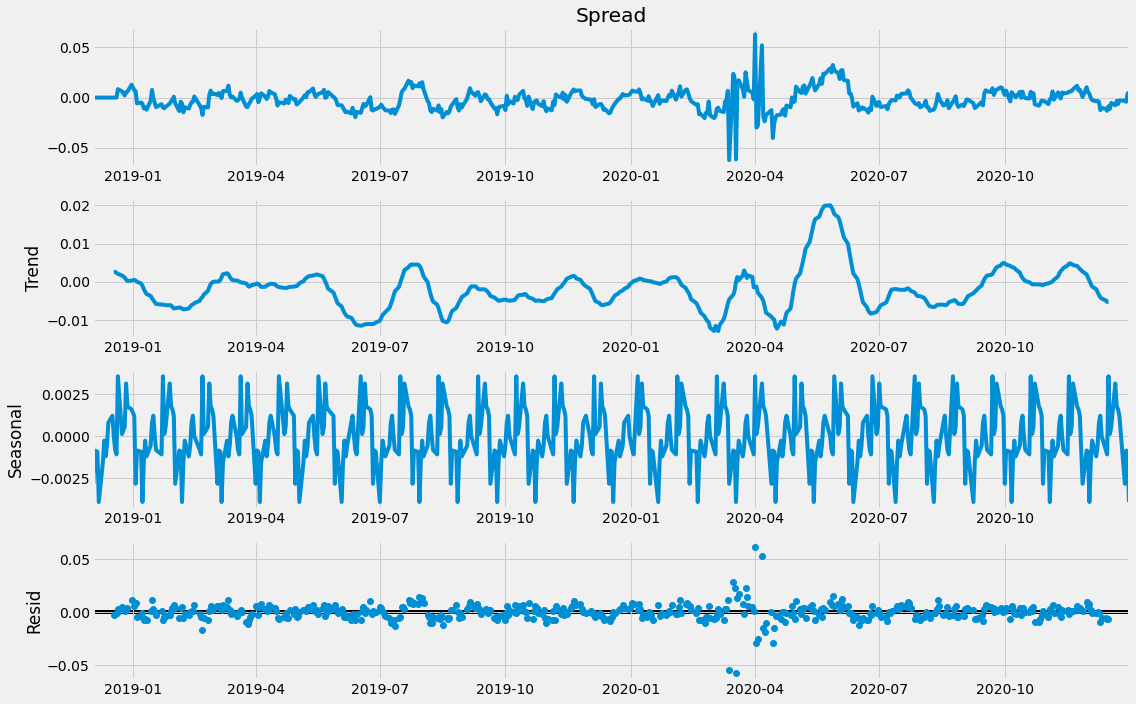

In [123]:
seasonality = sm.tsa.seasonal_decompose(data, model='additive', period=20)
plt.rcParams['figure.figsize'] = [16,10]
seasonality.plot()
plt.show()

The seasonality component is too small to be relevant here. The residual around the the news of COVID and how it started to heavily impact the market is fairly interesting. Let's look a little closer at the residual and it's distribution by runnign a QQ plot and an ADF test. Let's now look at the percentile required for us to enter and exit a position. 

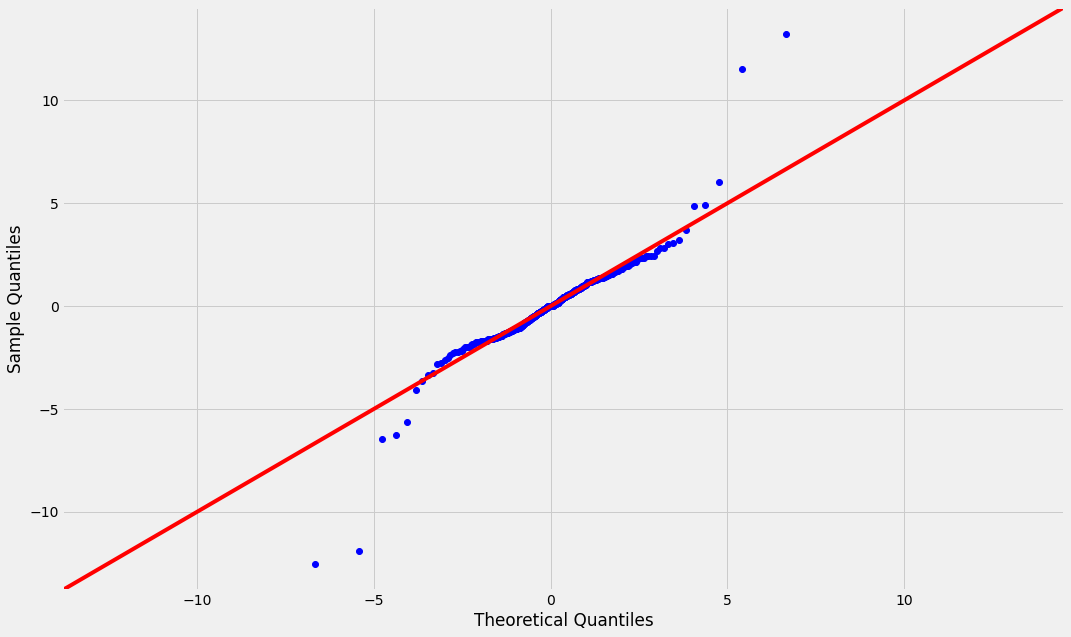

In [124]:
res = seasonality.resid
res = res.fillna(resid.mean())
plt.rcParams['figure.figsize'] = [16,10]
fig = sm.qqplot(res, sp.stats.t, fit=True, line="45")
plt.show()

In [125]:
ADF_spread = sm.tsa.stattools.adfuller(res.dropna().values)
print("ADF Stat: {:.4f} \n p-value: {:.4f}".format(ADF_spread[0], ADF_spread[1]))

ADF Stat: -8.0553 
 p-value: 0.0000


From the ADF statistics we cannot reject that the distribution of residuals is not normal but when we look at the QQ plot, we observe a few points that are significantly deviate from what we would explain if the distribution was normal, by not being around the red line. I believe that the reason that this doesn't affect the ADF stat is that the number of points outside their range is relative small and that is because the period of turbulance for the residual was short. Let's now look at the percentile required for us to enter and exit a position. 

In [126]:
def inverse_percentile(arr, num):
    arr = sorted(arr)
    i_arr = [i for i, x in enumerate(arr) if x > num]
    return 100 * i_arr[0] / len(arr) if len(i_arr) > 0 else 100

In [127]:
enter_perc = inverse_percentile(data, 0.025)
exit_perc = inverse_percentile(data, 0.02)

print("Percentile to enter a position = {:.2f}%, Percentile to exit a position = {:.2f}%".format(enter_perc, exit_perc))

Percentile to enter a position = 98.28%, Percentile to exit a position = 97.52%


This means that we enter a trade in less than 2% of days in a given year. Given that the percentile to exit is close to the percentile to open, we expect to close our position shortly after entering one. This creates an environment where we rarely make any trades, and when we do they are very short. Low frequency data is another reason for the poor estimate of the strategy for unseen data. Let's now look at a normalized returns of the strategy vs a normal distribution.  

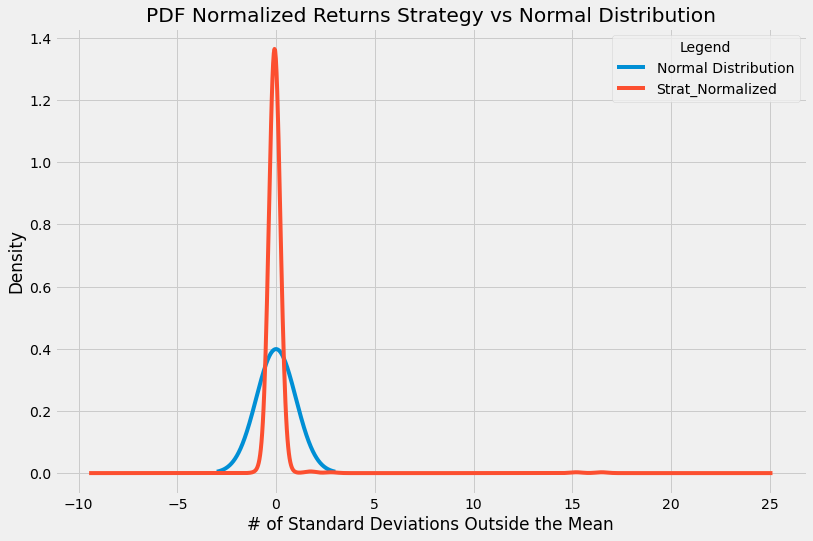

In [128]:
x = np.arange(-3,3,0.001)
y = pd.Series(norm.pdf(x,0,1), index = x, name = 'Normal Distribution')

data = df_optimized['Strat_Returns']
mean = data.mean()
std = data.std()
df_optimized['Strat_Normalized'] = (data - mean)/std

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x,y, label = 'Normal Distribution')
df_optimized['Strat_Normalized'].plot.kde()
ax.set_xlabel('# of Standard Deviations Outside the Mean')
ax.set_title('PDF Normalized Returns Strategy vs Normal Distribution')
plt.legend(loc='upper right', title='Legend')

As we expected from the high kurtosis of the strategy which comes from a very few data points with high returns and most points having 0 returns. We're not going to do any time-series analysis of the strategy given the few amount of data points we have for the strategy itself. From what we have gathered, there is significant doubt that our strategy will have significant correlation with Fama French Factors but let's do the analysis.

In [129]:
ff_df['Strat_Ret'] = df_optimized['Strat_Returns']
print(ff_df.isnull().sum().sum())
ff_df.fillna(0)

1


,Mkt-RF,SMB,HML,RF,Strat_Ret
Date,,,,,
2018-12-03,1.13,-0.07,-0.79,0.01,0.0
2018-12-04,-3.45,-0.96,-0.18,0.01,0.0
2018-12-06,-0.16,0.12,-1.04,0.01,0.0
2018-12-07,-2.36,0.19,1.33,0.01,0.0
2018-12-10,0.10,-0.15,-1.65,0.01,0.0
...,...,...,...,...,...
2020-12-24,0.21,-0.39,-0.17,0.00,0.0
2020-12-28,0.46,-0.72,0.32,0.00,0.0
2020-12-29,-0.40,-1.52,0.24,0.00,0.0


In [130]:
ff_df.corrwith(ff_df['Strat_Ret'])

Mkt-RF      -0.157575
SMB          0.225253
HML          0.012295
RF           0.008891
Strat_Ret    1.000000
dtype: float64

As expected we do not observe significant correlation with the market risk premium or other fama french factors. Because of the high starting capital and the nature of the strategy being a long/short where the long position is mostly financed through the short, measuring metrics such as the Sharpe Ratio, Sortino Ratio and Information Ration will not give us much insight with the small returns we are getting. Where the strategy might be attractive is the fact that it is mostly self-financing and a low-correlation to the market. Unfortunately, we do not many transactions and from the change of cash graphics, we see that we cannot test maximum drawdown or negative beta and generally not many metrics.

One thing we can do is test the strategy for a different time period and see how it behaves. The initial start and end date coincide with a bullish market for gold so let's see how it performs in a bearish timeframe. 

# 5. Different Time Period Analysis

We're going to run some similar tests for a different time period and see how the strategy performs with the same parameters we optimized for a bullish environment in a bearish environment. In 2012-13 a big amount of money moved from gold into equities. A combination of low-rates and withdrawal of stimulus post 2008-09 financial crisis removed the need for gold as an inflation hedge.

In [131]:
start = "2012-09-10"
end = "2013-12-27"
pair = ("EOD/RING", "EOD/GDX")
raw_data = fetch_quandl(pair, start, end)
raw_data.head()

,EOD/RING - Open,EOD/RING - High,EOD/RING - Low,EOD/RING - Close,EOD/RING - Volume,EOD/RING - Dividend,EOD/RING - Split,EOD/RING - Adj_Open,EOD/RING - Adj_High,EOD/RING - Adj_Low,...,EOD/GDX - Low,EOD/GDX - Close,EOD/GDX - Volume,EOD/GDX - Dividend,EOD/GDX - Split,EOD/GDX - Adj_Open,EOD/GDX - Adj_High,EOD/GDX - Adj_Low,EOD/GDX - Adj_Close,EOD/GDX - Adj_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2012-09-10,21.4100,21.410,21.1200,21.120,6500.0,0.0,1.0,39.010438,39.010438,38.482039,...,49.40,49.48,11893500.0,0.0,1.0,47.200584,47.313190,46.356041,46.431112,11893500.0
2012-09-11,21.1300,21.305,21.1200,21.245,3500.0,0.0,1.0,38.500260,38.819121,38.482039,...,49.58,49.81,9796700.0,0.0,1.0,46.853383,47.247504,46.524950,46.740778,9796700.0
2012-09-12,21.4000,21.400,20.8104,20.910,4100.0,0.0,1.0,38.992218,38.992218,37.917927,...,48.71,50.01,18235400.0,0.0,1.0,47.097363,47.144282,45.708558,46.928454,18235400.0
2012-09-13,21.0701,22.180,20.9300,22.180,11400.0,0.0,1.0,38.391118,40.413429,38.135846,...,49.24,52.52,32409600.0,0.0,1.0,46.815848,49.291111,46.205900,49.283791,32409600.0
2012-09-14,22.2900,23.100,22.2900,22.870,120700.0,0.0,1.0,40.613857,42.089730,40.613857,...,53.00,53.86,27035600.0,0.0,1.0,49.762366,50.747666,49.734214,50.541222,27035600.0


In [132]:
pair_data = clean_quandl_columns(raw_data)[['RING:Adj_Close','RING:Adj_Volume', 'GDX:Adj_Close','GDX:Adj_Volume']]
ring_data = pair_data[['RING:Adj_Close','RING:Adj_Volume']]
gdx_data = pair_data[['GDX:Adj_Close','GDX:Adj_Volume']]

def augment_df(df):
    ticker = df.columns[0].split(':')[0]
    df[ticker+':'+'Dollar_Volume'] = df[df.columns[0]] * df[df.columns[1]]
    df[ticker+':'+'15Day_Running_Median'] = df[ticker+':'+'Dollar_Volume'].shift(1).rolling(15).median()
    return df

ring_data = augment_df(ring_data)
gdx_data = augment_df(gdx_data)
data = ring_data.merge(gdx_data, left_index=True, right_index=True)
data[['Spread','RING:Mday_ret','GDX:Mday_ret','RING:shares','GDX:shares','RING:pos','GDX:pos','Gross','PnL', 'PnL_Accumulated']] = np.nan
K = data['RING:15Day_Running_Median'].max()
data['Capital'] = K
data.head(20)

<ipython-input-132-3af93cf17630>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,RING:Adj_Close,RING:Adj_Volume,RING:Dollar_Volume,RING:15Day_Running_Median,GDX:Adj_Close,GDX:Adj_Volume,GDX:Dollar_Volume,GDX:15Day_Running_Median,Spread,RING:Mday_ret,GDX:Mday_ret,RING:shares,GDX:shares,RING:pos,GDX:pos,Gross,PnL,PnL_Accumulated,Capital
Date,,,,,,,,,,,,,,,,,,,
2012-09-10,38.482039,3250.0,1.250666e+05,NaN,46.431112,11893500.0,5.522284e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177030e+06
2012-09-11,38.709797,1750.0,6.774215e+04,NaN,46.740778,9796700.0,4.579054e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177030e+06
2012-09-12,38.099405,2050.0,7.810378e+04,NaN,46.928454,18235400.0,8.557591e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177030e+06
2012-09-13,40.413429,5700.0,2.303565e+05,NaN,49.283791,32409600.0,1.597268e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177030e+06
2012-09-14,41.670655,60350.0,2.514824e+06,NaN,50.541222,27035600.0,1.366412e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177030e+06
2012-09-17,41.597772,10100.0,4.201375e+05,NaN,50.569374,12992700.0,6.570327e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177030e+06
2012-09-18,41.579552,2850.0,1.185017e+05,NaN,50.972878,16323500.0,8.320558e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177030e+06
2012-09-19,42.326599,5950.0,2.518433e+05,NaN,51.413917,15389300.0,7.912242e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177030e+06
2012-09-20,42.199054,2550.0,1.076076e+05,NaN,51.010413,11582300.0,5.908179e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177030e+06


In [133]:
df = cum_pnl_pair_strategy(0.02,0.025,0.0044,13,data, threshold_day ='2012-10-01')[0]
pos_df = cum_pnl_pair_strategy(0.02,0.025,0.0044,13,data, threshold_day ='2012-10-01')[2]

In [134]:
df.tail()

,RING:Adj_Close,RING:Adj_Volume,RING:Dollar_Volume,RING:15Day_Running_Median,GDX:Adj_Close,GDX:Adj_Volume,GDX:Dollar_Volume,GDX:15Day_Running_Median,Spread,RING:Mday_ret,GDX:Mday_ret,RING:shares,GDX:shares,RING:pos,GDX:pos,Gross,PnL,PnL_Accumulated,Capital,Cash_Pos
Date,,,,,,,,,,,,,,,,,,,,
2013-12-20,16.324787,144350.0,2.356483e+06,1.107165e+06,19.463419,26982400.0,5.251697e+08,7.767715e+08,-0.009714,0.007768,-0.001946,0.0,0.0,0.0,0.0,0.0,0.0,326.731964,1.177356e+06,1.177356e+06
2013-12-23,16.231821,50350.0,8.172722e+05,1.177030e+06,19.511769,18645900.0,3.638145e+08,7.767715e+08,-0.007305,-0.023270,-0.030576,0.0,0.0,0.0,0.0,0.0,0.0,326.731964,1.177356e+06,1.177356e+06
2013-12-24,16.808209,40850.0,6.866153e+05,1.107165e+06,20.124203,34891900.0,7.021717e+08,6.772021e+08,-0.008080,0.034670,0.026590,0.0,0.0,0.0,0.0,0.0,0.0,326.731964,1.177356e+06,1.177356e+06
2013-12-26,16.808209,33200.0,5.580325e+05,1.104011e+06,20.143342,18396900.0,3.705750e+08,6.772021e+08,-0.007785,0.035810,0.028025,0.0,0.0,0.0,0.0,0.0,0.0,326.731964,1.177356e+06,1.177356e+06
2013-12-27,16.901174,97950.0,1.655470e+06,1.104011e+06,20.334728,20863900.0,4.242617e+08,6.282822e+08,-0.009801,0.021009,0.011208,0.0,0.0,0.0,0.0,0.0,0.0,326.731964,1.177356e+06,1.177356e+06


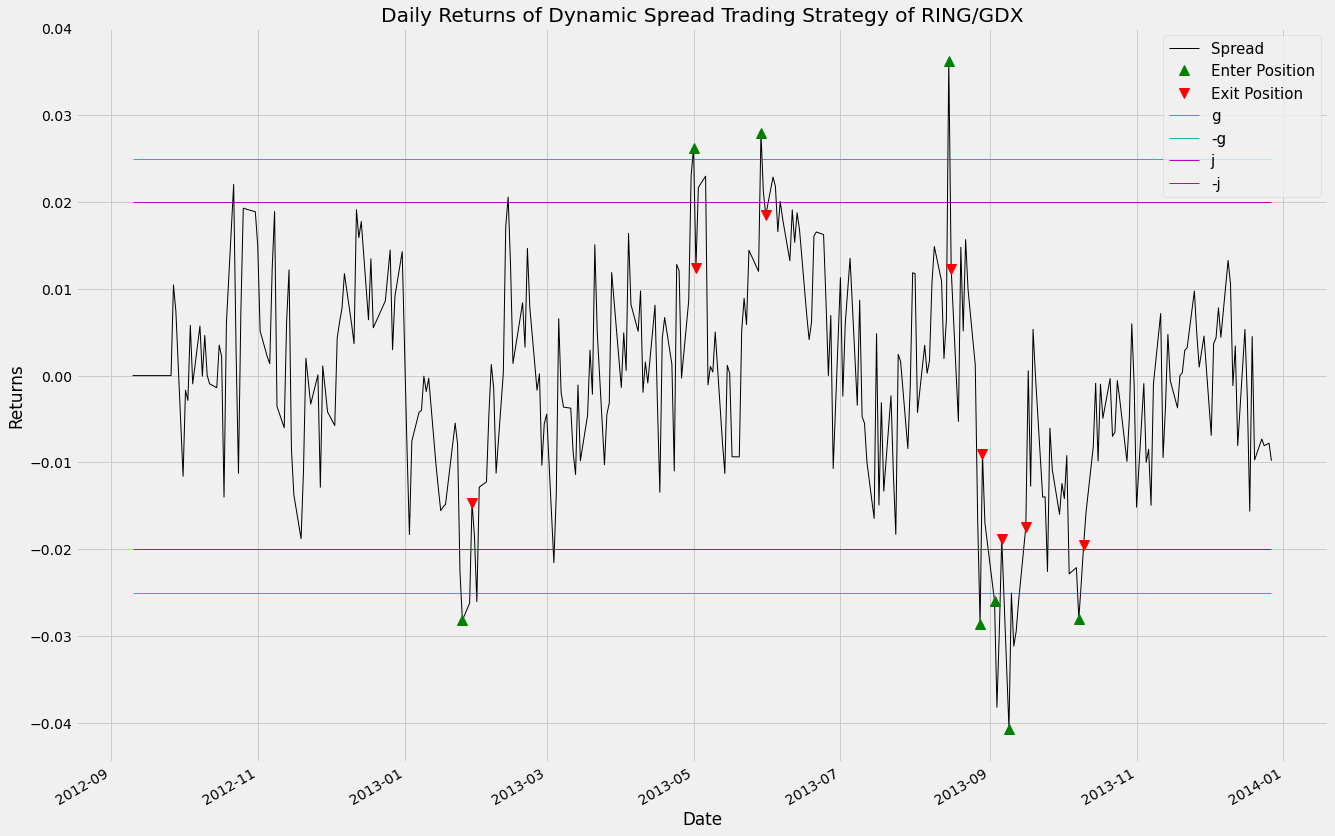

In [135]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)

df['Spread'].plot(c = 'k',lw = 1)
ax.plot(pos_df[pos_df['Enter Position'] != 0].index,pos_df['Enter Position'][pos_df['Enter Position'] != 0], '^',markersize = 10, c='g', label='Enter Position')
ax.plot(pos_df[pos_df['Exit Position'] != 0].index,pos_df['Exit Position'][pos_df['Exit Position'] != 0], 'v',markersize = 10, c='red', label='Exit Position')
ax.set_title('Daily Returns of Dynamic Spread Trading Strategy of RING/GDX')
ax.set_ylabel('Returns')
ax.hlines(y=g, xmin = df.index[0], xmax = df.index[-1], color = 'c', lw=1, label ='g')
ax.hlines(y=-g, xmin = df.index[0], xmax = df.index[-1], color = 'c', lw=1, label ='-g')
ax.hlines(y=j, xmin = df.index[0], xmax = df.index[-1], color = 'm', lw=1, label ='j')
ax.hlines(y=-j, xmin = df.index[0], xmax = df.index[-1], color = 'm', lw=1, label ='-j')
ax.legend(fontsize = 15)
plt.show()

In [136]:
pos_df[pos_df['Enter Position'] != 0].count()

Enter Position    8
Exit Position     8
dtype: int64

We only have 8 positions this time instead of 7, not much improvement in terms of frequency, although the period is shorter here. 

In [137]:
enter_pos_idx = pos_df[pos_df['Enter Position'] != 0].index
exit_pos_idx = pos_df[pos_df['Exit Position'] != 0].index
sum((exit_pos_idx-enter_pos_idx).days)/len((exit_pos_idx-enter_pos_idx).days)

2.625

Our average holding time actually decreases! Most of the time this strategy will not be active. This is in large because the point of entry is far from the average daily returns. 

In [138]:
spread_stats = pd.DataFrame(data = None, columns = ['Spread Returns'], index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])
data = df['Spread']

spread_stats.loc['Mean'] = data.mean()
spread_stats.loc['Median'] = data.median()
spread_stats.loc['Std Dev'] = data.std()
spread_stats.loc['1st Quartile'] = data.quantile(0.25)
spread_stats.loc['3rd Quartile'] = data.quantile(0.75)
spread_stats.loc['Skew'] = sp.stats.skew(data.dropna())
spread_stats.loc['Kurtosis'] = sp.stats.kurtosis(data.dropna())

spread_stats

,Spread Returns
Mean,-0.000512
Median,0.0
Std Dev,0.012037
1st Quartile,-0.008419
3rd Quartile,0.006631
Skew,-0.275641
Kurtosis,0.329492


Let's check the normality of the spread for the bearish environment. 

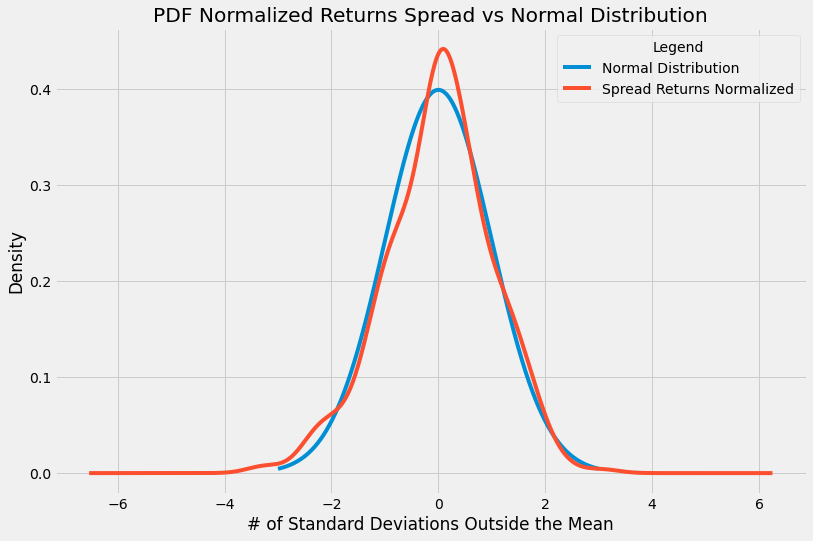

In [139]:
x = np.arange(-3,3,0.001)
y = pd.Series(norm.pdf(x,0,1), index = x, name = 'Normal Distribution')

mean = data.mean()
std = data.std()
df['Spread Returns Normalized'] = (data - mean)/std

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x,y, label = 'Normal Distribution')
df['Spread Returns Normalized'].plot.kde()
ax.set_xlabel('# of Standard Deviations Outside the Mean')
ax.set_title('PDF Normalized Returns Spread vs Normal Distribution')
plt.legend(loc='upper right', title='Legend')

Indeed we observe some of the negative knewness and kurtosis as previously calculated.  Let's test the normality of the spread by running D'Agostino and Pearson's test that tests the null hypothesis that a sample comes from a normal distribution.

In [140]:
print('P-value of the D\'Agostino and Pearson\'s test = {}'.format(sp.stats.normaltest(df['Spread Returns Normalized'])[1]))

P-value of the D'Agostino and Pearson's test = 0.05450314515975056


In this case, we cannot reject the null hypothesis with a 95% confidence level that the distribution of the returns are normal. The evidence here is a lot less stronger than it was for the bullish timeframe. Considering the economic turbulence of the previous timeframe due to COVID, it is expected that the returns deviate more considering the rarity of such events in the market and the increase of volatility. Let's look at some time-series analysis and starting with autocorrelation and partial autocorrelation. 

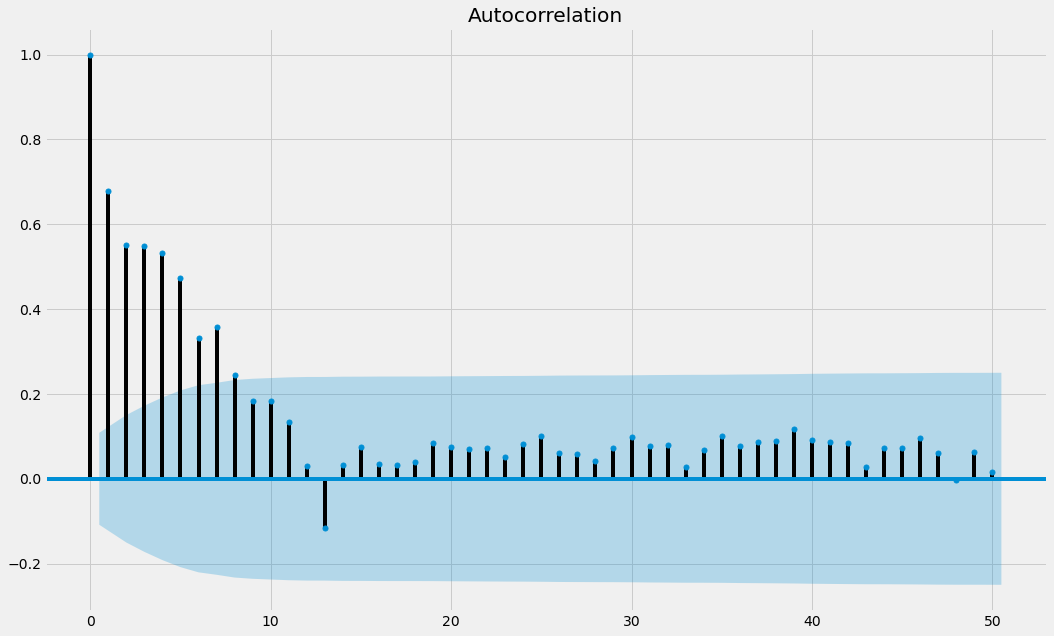

In [141]:
fig1, ax = plt.subplots(figsize=(16,10))
fig1 = sm.graphics.tsa.plot_acf(data, ax = ax, lags = 50)

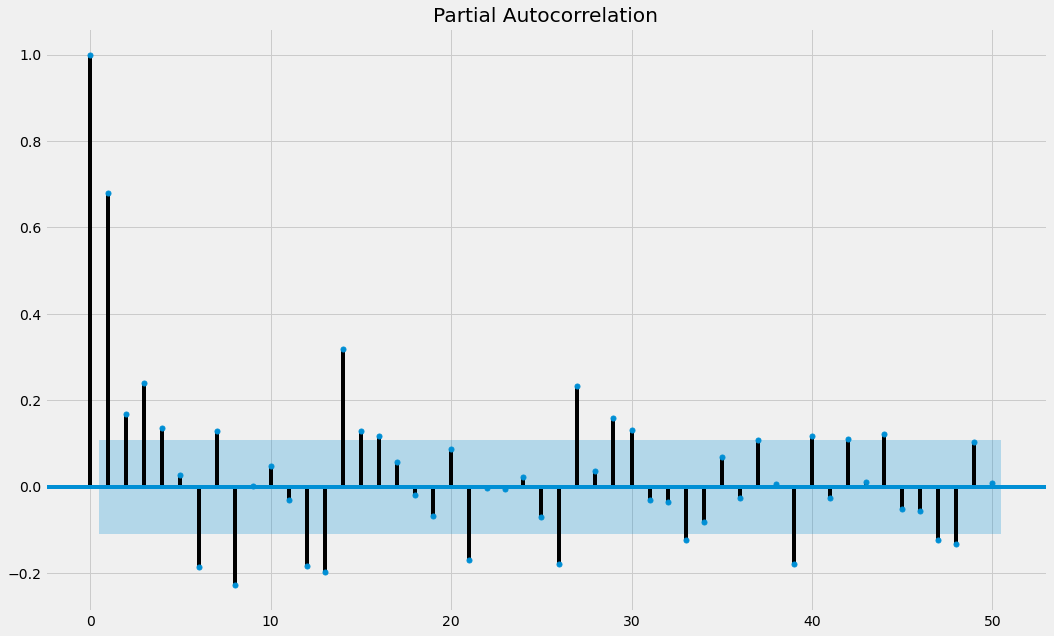

In [142]:
fig1, ax = plt.subplots(figsize=(16,10))
fig1 = sm.graphics.tsa.plot_pacf(data, ax = ax, lags = 50)

There does seem to have some autocorrelation for a short amount of lag in the first graphic and from the partial autocorrelation graph. Let's look at the first values of the acf plots and estimate of the pacf using the Yule-Walker method.

In [143]:
sm.tsa.stattools.acf(data, nlags = 10)

array([1.        , 0.67874741, 0.55009529, 0.54806611, 0.53212038,
       0.47279165, 0.33079848, 0.35706544, 0.24366299, 0.18308817,
       0.18426367])

In [144]:
sm.tsa.stattools.pacf_yw(data, nlags = 5)

array([1.        , 0.68082946, 0.16767299, 0.24039983, 0.13532874,
       0.02756783])

There is significant amount of lags up to 4 periods where the pacf values are outside of the 95% confidence interval of no partial autocorrelation among the values. We can check for normality using Augmented Dickey Fuller Test.

In [145]:
ADF_spread = sm.tsa.stattools.adfuller(data.dropna().values)
print("ADF Stat: {:.4f} \n p-value: {:.4f}".format(ADF_spread[0], ADF_spread[1]))

ADF Stat: -2.8175 
 p-value: 0.0558


With a ADF value less than (-3.44, -2.87) which are the critical values for the sample size and (1%,5%) confidence interval for t-distribution for sample ~500. Compined with the p-value which is greater than 0.05, we cannot say with confidence that our spread returns is not normaly distributed. Let's look if there is any seasonality in the returns.

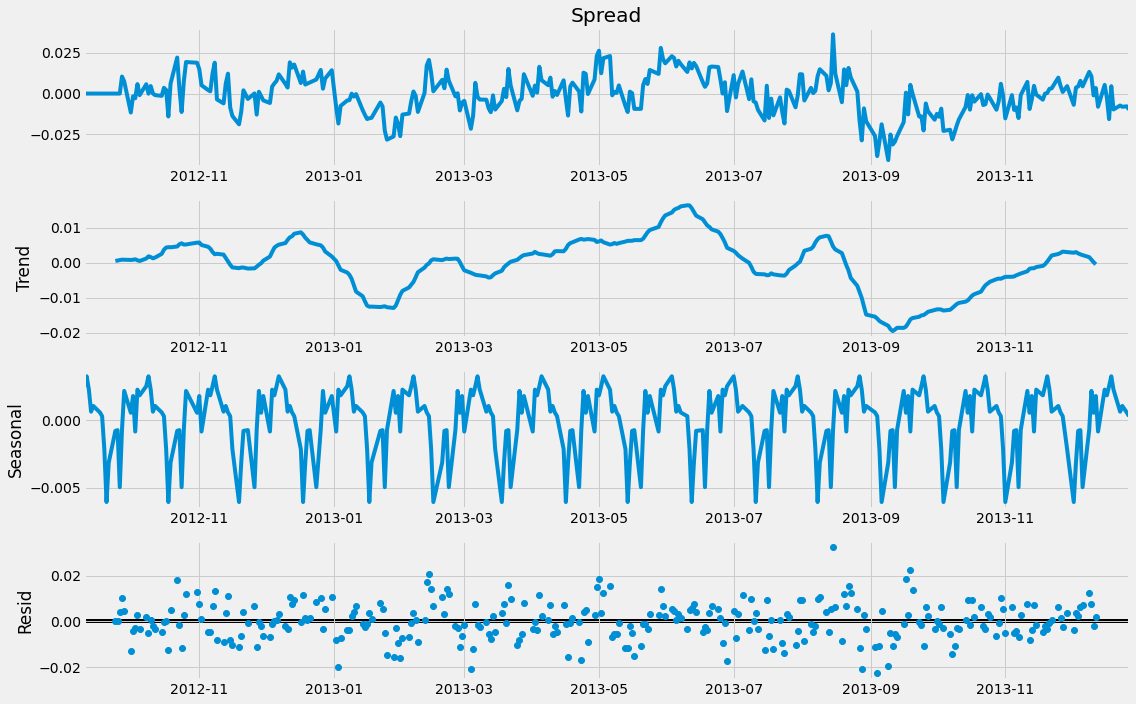

In [146]:
seasonality = sm.tsa.seasonal_decompose(data, model='additive', period=20)
plt.rcParams['figure.figsize'] = [16,10]
seasonality.plot()
plt.show()

Again, we observe that the seasonality is fairly small in the returns but this time the residual are much more regular and constant and evenly distributed than they were in the previous timeframe due to COVID. Let's look at a QQ plot of the distribution of the residual. 

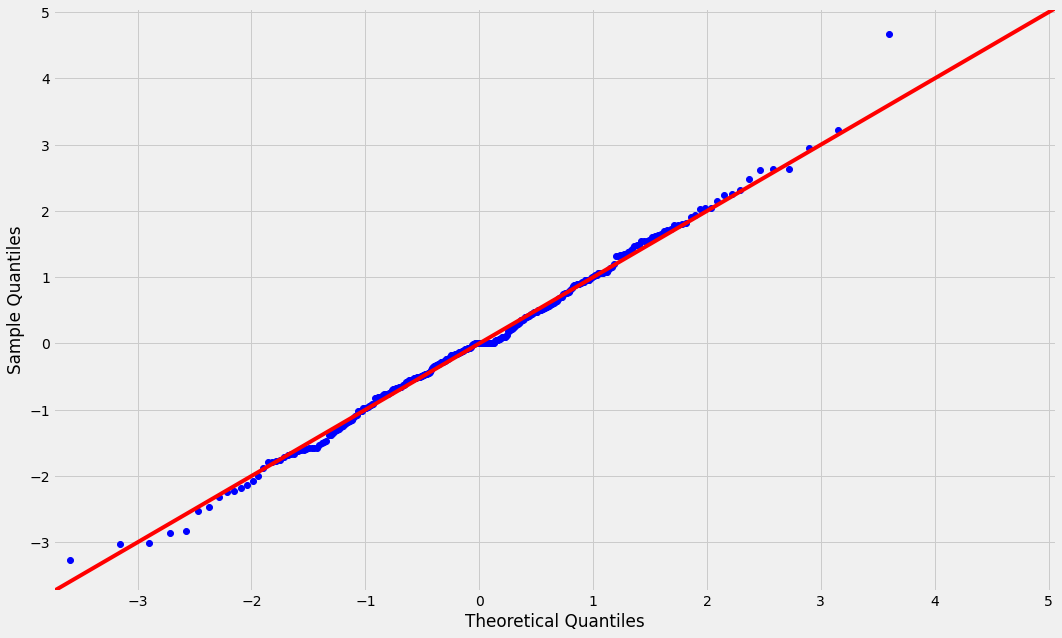

In [147]:
res = seasonality.resid
res = res.fillna(resid.mean())
plt.rcParams['figure.figsize'] = [16,10]
fig = sm.qqplot(res, sp.stats.t, fit=True, line="45")
plt.show()

In [148]:
ADF_spread = sm.tsa.stattools.adfuller(res.dropna().values)
print("ADF Stat: {:.4f} \n p-value: {:.4f}".format(ADF_spread[0], ADF_spread[1]))

ADF Stat: -7.7582 
 p-value: 0.0000


After the ADF test and the QQ plot, it does seem like the residual follow a normal distribution in this case. Back to strategy, let's look at some statistics in regards to the frequency of entry and exit position.

In [149]:
enter_perc = inverse_percentile(data, 0.025)
exit_perc = inverse_percentile(data, 0.02)

print("Percentile to enter a position = {:.2f}%, Percentile to exit a position = {:.2f}%".format(enter_perc, exit_perc))

Percentile to enter a position = 99.08%, Percentile to exit a position = 96.33%


This is expected from the low number of trades and the average daily returns and the corridor in the graph above of the daily returns over time. Let's now check how the strategy performs. 

Text(0.5, 1.0, 'Change of cash position over time for the trading strategy')

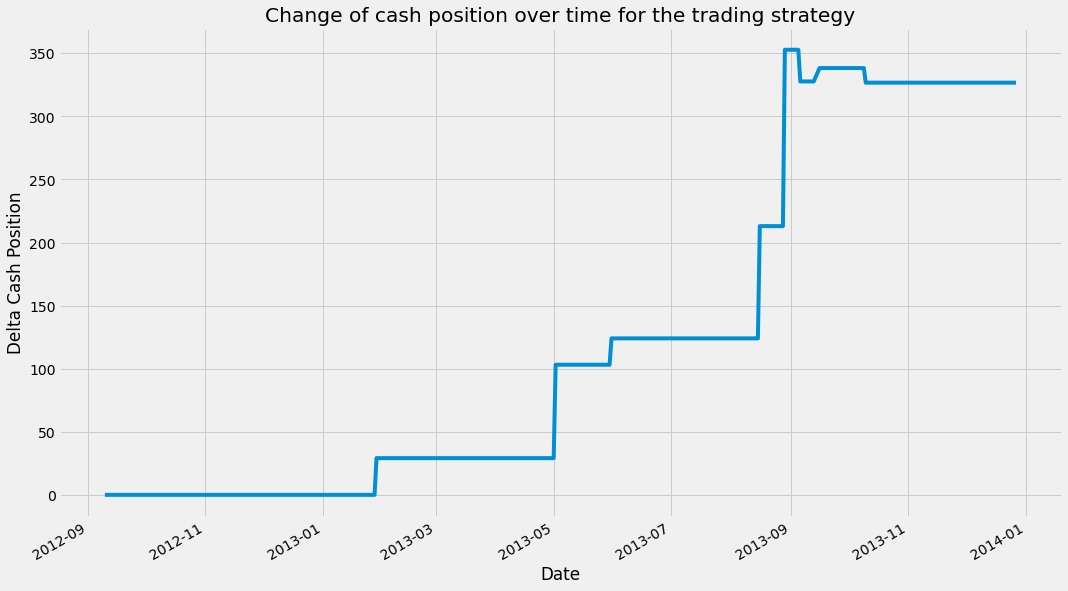

In [150]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)


(df['Cash_Pos']-df['Cash_Pos'].iloc[0]).plot()
ax.set_ylabel('Delta Cash Position')
ax.set_title('Change of cash position over time for the trading strategy')

We observe a similar step wise pattern that results from the strategy taking very few bets but because each bet is rare and each bet is taken when the spread is far from it's average we observe a lot of small winning bets. The positions do seem high for the PnL that one would achieve with this strategy but if it can be financed by the short and high leverage, this could be a potential strategy that generates small income over time.